In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### variables used for training

In [2]:
variables = ['subleadingPhoton_pt', 'leadingPhoton_pt'     , 'subleadingPhoton_eta'        ,
             'leadingPhoton_eta'  , 'subleadingJet_pt'     , 'leadingJet_pt'               , 
             'subleadingJet_eta'  , 'leadingJet_eta'       , 'leadingJet_DeepCSV'          ,  
             'PhoJetMinDr'        , 'subleadingJet_DeepCSV', 'dijetCandidatePtOverdiHiggsM', 
             'absCosTheta_bb'     , 'HHbbggMVA'            , 'absCosThetaStar_CS'          , 
             'sigmaMJets'         , 'PhoJetotherDr']
w = ['weight']

In [3]:
treename = 'bbggSelectionTree'
filename = {}
upfile = {}
params = {}
weights = {}
df = {}

filename['sig'] = 'Files/Signal_merged.root' # path to files
filename['bkg'] = 'Files/Bkg_merged.root'

upfile['bkg'] = uproot.open(filename['bkg'])
upfile['sig'] = uproot.open(filename['sig'])

params['bkg'] = upfile['bkg'][treename].arrays(variables)
params['sig'] = upfile['sig'][treename].arrays(variables)

weights['bkg'] = upfile['bkg'][treename].arrays(w)
weights['sig'] = upfile['sig'][treename].arrays(w)

df['sig'] = pd.DataFrame(params['sig'])
df['bkg'] = pd.DataFrame(params['bkg'])

weights_sig = pd.DataFrame(weights['sig'])
weights_bkg = pd.DataFrame(weights['bkg'])

weights_bkg *= 10000.
weights_sig *= 100000.
sample_weights = np.concatenate([weights_sig, weights_bkg])

#getting a numpy array from two pandas data frames
X_ = np.concatenate([df['sig'].values,df['bkg'].values])
#creating numpy array for target variables
Y = np.concatenate([np.ones(len(df['sig'])),
                        np.zeros(len(df['bkg']))])
print(X_)

df2 = pd.DataFrame(X_)
df2.head()


[[ 7.22487411e+01  1.30155106e+02 -1.38112152e+00 ...  6.87454343e-01
   1.34371281e-01  2.24524546e+00]
 [ 4.72007790e+01  1.70818069e+02 -4.39545996e-02 ...  3.50090355e-01
   6.31418079e-02  3.23068118e+00]
 [ 5.23401871e+01  1.91114853e+02  2.17155516e-01 ...  1.10923506e-01
   6.03511855e-02  2.87924099e+00]
 ...
 [ 6.49209976e+01  6.58984528e+01 -8.29264045e-01 ...  9.68705177e-01
   1.04560807e-01  3.17477751e+00]
 [ 4.41462059e+01  8.06903534e+01 -3.64570856e-01 ...  6.48728371e-01
   7.91566297e-02  2.21153641e+00]
 [ 3.70323639e+01  1.22164246e+02 -1.17238069e+00 ...  2.46764794e-01
   1.48466468e-01  2.93314481e+00]]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,72.248741,130.155106,-1.381122,-0.983321,60.271523,173.781281,-0.290333,0.280785,0.107359,1.627427,0.937772,0.300940,0.323522,0.221290,0.687454,0.134371,2.245245
1,47.200779,170.818069,-0.043955,-0.132630,32.632187,138.225998,-2.051849,-0.309031,0.640311,1.913295,0.043082,0.373334,0.663933,0.345626,0.350090,0.063142,3.230681
2,52.340187,191.114853,0.217156,-0.764093,40.515575,125.473175,-1.641922,-0.541176,0.999677,2.541774,0.978204,0.363827,0.557005,0.958707,0.110924,0.060351,2.879241
3,56.015404,60.226284,0.388162,1.242162,115.318954,273.932983,-0.532042,0.024166,0.905206,0.776604,0.803230,0.879961,0.817004,0.423930,0.508766,0.048089,3.157310
4,40.310959,501.206635,1.950851,1.140412,31.213484,244.626251,-0.135219,0.975129,0.997151,1.412559,0.992393,0.484264,0.866719,0.970944,0.455877,0.070914,2.119584


### baseline keras model

In [4]:
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(variables)
inputs = Input(shape=(NDIM,), name = 'input') 
hidden = Dense(100, activation='relu')(inputs)
hidden = Dropout(0.73, noise_shape=None, seed=None)(hidden)
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,901
Trainable params: 1,901
Non-trainable params: 0
_________________________________________________________________


In [5]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test, w_train, w_test = train_test_split(X_, Y, sample_weights, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)
print(Y_test)

[0. 1. 0. ... 1. 1. 1.]


### Train classifier

In [6]:
history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=300, 
                    batch_size=1024,
                    sample_weight = w_train.flatten(),
                    verbose=1,# switch to 1 for more verbosity 
                    callbacks=[model_checkpoint, early_stopping], 
                    validation_split=0.25)

Instructions for updating:
Use tf.cast instead.
Train on 130578 samples, validate on 43527 samples
Epoch 1/300
130578/130578 [==============================] - 1s 7us/step - loss: 0.3117 - acc: 0.7978 - val_loss: 0.1973 - val_acc: 0.8887
Epoch 2/300
130578/130578 [==============================] - 1s 4us/step - loss: 0.1971 - acc: 0.8946 - val_loss: 0.1711 - val_acc: 0.9092
Epoch 3/300
130578/130578 [==============================] - 1s 4us/step - loss: 0.1834 - acc: 0.9047 - val_loss: 0.1679 - val_acc: 0.9127
Epoch 4/300
130578/130578 [==============================] - 1s 4us/step - loss: 0.1798 - acc: 0.9087 - val_loss: 0.1666 - val_acc: 0.9144
Epoch 5/300
130578/130578 [==============================] - 1s 4us/step - loss: 0.1775 - acc: 0.9102 - val_loss: 0.1659 - val_acc: 0.9144
Epoch 6/300
130578/130578 [==============================] - 1s 4us/step - loss: 0.1766 - acc: 0.9122 - val_loss: 0.1652 - val_acc: 0.9149
Epoch 7/300
130578/130578 [==============================] - 1s 4us

In [7]:
# graph with best TMVA performance
Graph_fx1= [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9999906, 0.9999437, 0.9998498, 0.9996339, 0.9993804, 0.9987702, 0.9975874, 0.9959916, 0.9933443, 0.9896738, 0.984445, 0.9771415, 0.9659892, 0.9502464, 0.9280544, 0.8961277, 0.8546914, 0.8003661, 0.7380897, 0.6663506, 0.5873832, 0.5029899, 0.4138465, 0.3245999, 0.2405163, 0.1644121, 0.1034217, 0.05995774, 0.0309974, 0.01375264, 0.005285144, 0.001811802, 0.000525713, 0.0001502037, 9.357929e-06, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Graph_fy1 = [2.373488e-316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0003282994, 0.003282994, 0.01083388, 0.02757715, 0.0528562, 0.09422193, 0.1421537, 0.1999343, 0.2652659, 0.3315824, 0.3959291, 0.455023, 0.5233092, 0.5873277, 0.6434668, 0.7150361, 0.7721602, 0.8237032, 0.8722915, 0.9090611, 0.9349967, 0.9520683, 0.9697965, 0.9826002, 0.9894944, 0.993434, 0.9960604, 0.9970453, 0.9983585, 0.9996717, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

for i in range(0, 100):
    Graph_fx1[i]=1-Graph_fx1[i]

print(Graph_fx1)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.400000000048259e-06, 5.630000000000912e-05, 0.00015019999999998923, 0.00036610000000003584, 0.0006196000000000534, 0.0012297999999999476, 0.002412599999999987, 0.004008400000000023, 0.006655700000000042, 0.010326199999999952, 0.015554999999999986, 0.022858500000000004, 0.03401080000000001, 0.04975359999999995, 0.07194560000000005, 0.10387230000000003, 0.1453086, 0.19963390000000003, 0.26191030000000004, 0.3336494, 0.4126168, 0.4970101, 0.5861535, 0.6754001000000001, 0.7594837, 0.8355878999999999, 0.8965783, 0.94004226, 0.9690026, 0.98624736, 0.994714856, 0.998188198, 0.999474287, 0.9998497963, 0.999990642071, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


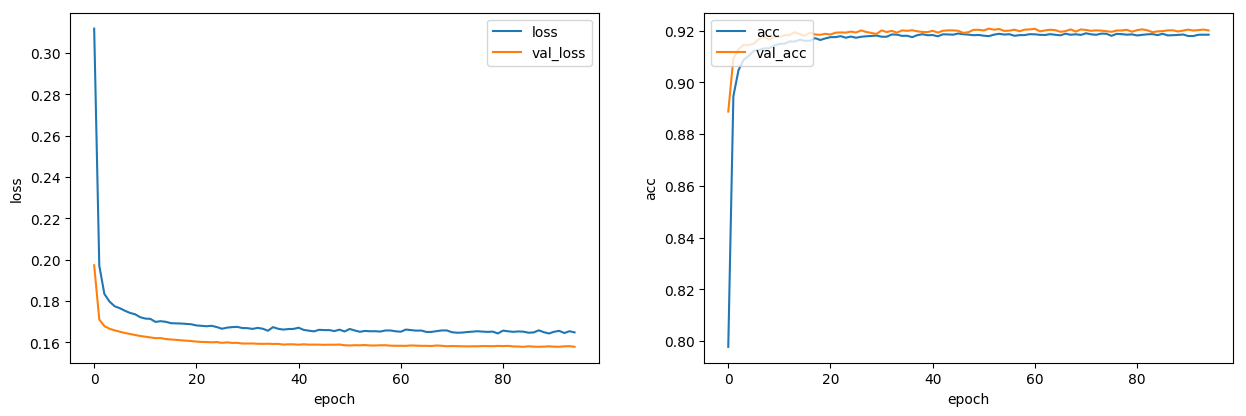

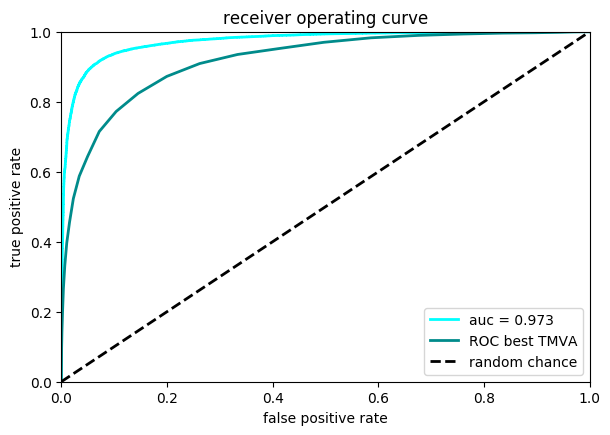

In [8]:
plt.style.use('default')

# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

lw=2
# Plot ROC
plt.figure(figsize=(15,10))
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
plt.plot(Graph_fx1, Graph_fy1, color='darkcyan', lw=lw, label='ROC best TMVA')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()

In [9]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0]),...] = value  

TPR_thresholds = [0.98, 0.95, 0.935, 0.9, 0.7, 0.5, 0.3]

fprs = []
base_tpr = np.linspace(0, 1, 5000)
print(base_tpr.shape, tpr.shape, fpr.shape)
thresholds = []
volatile=True
best_batch_size = 1000

(5000,) (6814,) (6814,)


# Plot with Signal/background discrimination

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


disc_bkg:  [0.09549174 0.2201131  0.04844281 ... 0.22207844 0.10578963 0.10354443]
disc_signal:  [0.83631897 0.9911649  0.9360305  ... 0.9979658  0.94242406 0.9845201 ]


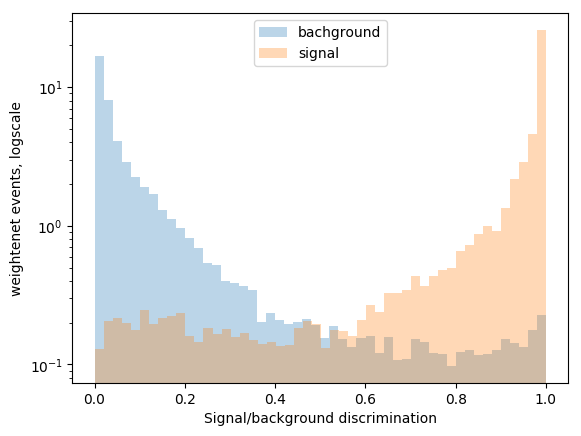

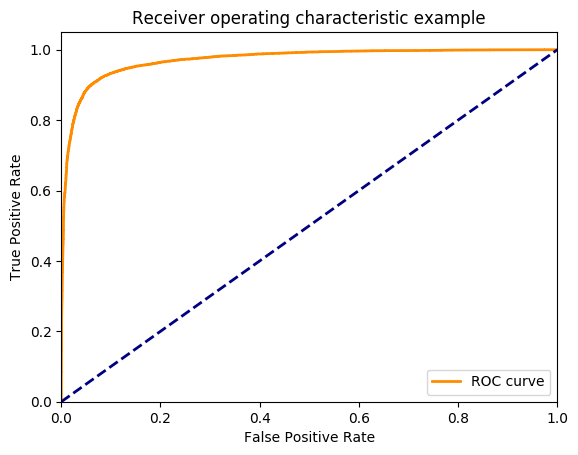

In [13]:
y_frame = pd.DataFrame({'truth':Y_test, 'disc':Y_predict.flatten(), 'weight':w_test.flatten()})
disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
weight_bkg = y_frame[y_frame['truth'] == 0]['weight'].values
weight_signal = y_frame[y_frame['truth'] == 1]['weight'].values
plt.figure()
plt.yscale("log")
plt.hist(disc_bkg, weights=weight_bkg, normed=True, bins=50, alpha=0.3, label='bachground')
plt.hist(disc_signal, weights=weight_signal, normed=True, bins=50, alpha=0.3, label='signal')
plt.xlabel('Signal/background discrimination')
plt.ylabel('weightenet events, logscale')
plt.savefig('mydiscriminator.png')
print ("disc_bkg: ", disc_bkg)
print ("disc_signal: ", disc_signal)
fpr, tpr, threshold = roc_curve(Y_test, Y_predict, sample_weight = w_test)
plt.legend()
plt.figure()


lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.show()
plt.savefig('myroc_' + '.png')

# Apply to another files
## these files do not contain PhoJetotherDr variable!

In [ ]:
variables = ['subleadingPhoton_pt', 'leadingPhoton_pt'     , 'subleadingPhoton_eta'        ,
             'leadingPhoton_eta'  , 'subleadingJet_pt'     , 'leadingJet_pt'               , 
             'subleadingJet_eta'  , 'leadingJet_eta'       , 'leadingJet_DeepCSV'          ,  
             'PhoJetMinDr'        , 'subleadingJet_DeepCSV', 'dijetCandidatePtOverdiHiggsM', 
             'absCosTheta_bb'     , 'HHbbggMVA'            , 'absCosThetaStar_CS'          , 
             'sigmaMJets'        ]

In [ ]:
#filename = {}
treename = {}
#upfile = {}
#params = {}
#weights = {}
#df = {}

filename['sigtest'] = 'output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'
filename['bkg_DiPhoton'] = 'output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root'
filename['bkg_GJet20ti40'] = 'output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root'
filename['bkg_GJet40toInf'] = 'output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root'

treename['sigtest'] = 'tagsDumper/trees/GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0'
treename['bkg_DiPhoton'] = 'tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0'
treename['bkg_GJet20ti40'] = 'tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0'
treename['bkg_GJet40toInf'] = 'tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0'


upfile['sigtest'] = uproot.open(filename['sigtest'])
upfile['bkg_DiPhoton'] = uproot.open(filename['bkg_DiPhoton'])
upfile['bkg_GJet20ti40'] = uproot.open(filename['bkg_GJet20ti40'])
upfile['bkg_GJet40toInf'] = uproot.open(filename['bkg_GJet40toInf'])

params['sigtest'] = upfile['sigtest'][treename['sigtest']].arrays(variables)
params['bkg_DiPhoton'] = upfile['bkg_DiPhoton'][treename['bkg_DiPhoton']].arrays(variables)
params['bkg_GJet20ti40'] = upfile['bkg_GJet20ti40'][treename['bkg_GJet20ti40']].arrays(variables)
params['bkg_GJet40toInf'] = upfile['bkg_GJet40toInf'][treename['bkg_GJet40toInf']].arrays(variables)

df['sigtest'] = pd.DataFrame(params['sigtest']) 
df['bkg_DiPhoton'] = pd.DataFrame(params['bkg_DiPhoton']) 
df['bkg_GJet20ti40'] = pd.DataFrame(params['bkg_GJet20ti40']) 
df['bkg_GJet40toInf'] = pd.DataFrame(params['bkg_GJet40toInf']) 

In [ ]:
X_sig = df['sigtest'].values
X_bkg_DiPhoton = df['bkg_DiPhoton'].values
X_bkg_GJet20ti40 = df['bkg_GJet20ti40'].values
X_bkg_GJet40toInf = df['bkg_GJet40toInf'].values

In [ ]:
X_bkg= scaler.transform(df['bkg'].values)
X_sig= scaler.transform(X_sig)
X_bkg_DiPhoton= scaler.transform(X_bkg_DiPhoton)
X_bkg_GJet20ti40= scaler.transform(X_bkg_GJet20ti40)
X_bkg_GJet40toInf= scaler.transform(X_bkg_GJet40toInf)

Y_sig_predict = model.predict(X_sig)
Y_bkg_predict = model.predict(X_bkg)
Y_bkg_DiPhoton = model.predict(X_bkg_DiPhoton)
Y_bkg_GJet20ti40 = model.predict(X_bkg_GJet20ti40)
Y_bkg_GJet40toInf = model.predict(X_bkg_GJet40toInf)


In [ ]:
weights_sig_test = rp.read_root(filename['sigtest'],
                             treename['sigtest'], columns=['weight']).values

weights_bkg_test = rp.read_root('Bkg_merged.root',
                            'bbggSelectionTree', columns=['weight']).values

weights_bkg_DiPhoton = rp.read_root(filename['bkg_DiPhoton'],
                             treename['bkg_DiPhoton'], columns=['weight']).values

weights_bkg_GJet20ti40 = rp.read_root(filename['bkg_GJet20ti40'],
                             treename['bkg_GJet20ti40'], columns=['weight']).values

weights_bkg_GJet40toInf = rp.read_root(filename['bkg_GJet40toInf'],
                             treename['bkg_GJet40toInf'], columns=['weight']).values
#print(weights_sig_test, weights_bkg_DiPhoton, weights_bkg_GJet20ti40, weights_bkg_GJet40toInf)

weights_sig_test *= 100000.
weights_bkg_DiPhoton *= 10000.
weights_bkg_GJet20ti40 *= 1000.
weights_bkg_GJet40toInf *= 100.

In [ ]:
Y_bkg_DiPhoton

In [ ]:
#y_frame = pd.DataFrame({'truth':Y_test, 'disc':Y_predict.flatten(), 'weight':w_test.flatten()})
#disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
#disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
#weight_bkg  = y_frame[y_frame['truth'] == 0]['weight'].values
#weight_signal = y_frame[y_frame['truth'] == 1]['weight'].values
#plt.figure()
#plt.yscale("log")

#plt.hist(Y_bkg_DiPhoton, weights=weights_bkg_DiPhoton, normed=True, bins=50, alpha=0.3, color = "blue")
#plt.hist(Y_bkg_GJet20ti40, weights=weights_bkg_GJet20ti40, normed=True, bins=50, alpha=0.3, color = "yellow")
#plt.hist(Y_bkg_GJet40toInf, weights=weights_bkg_GJet40toInf, normed=True, bins=50, alpha=0.3, color = "orange")
plt.hist(Y_sig_predict, normed=True, bins=50, alpha=0.3, color = "red", label='signal')
plt.hist(Y_bkg_GJet20ti40, normed=True, bins=50, alpha=0.3, color = "green", label='background')
plt.legend(loc='best')
plt.figure()

In [ ]:
pred_df = pd.DataFrame(Y_bkg_DiPhoton)
pred_df.head()

In [ ]:
pred_df.columns = ['ggHkiller']
print(pred_df.shape)
print(df['bkg_DiPhoton'].shape)
pred_df.head()

In [ ]:
df['bkg_DiPhoton']['ggHkiller'] = pred_df
df['bkg_DiPhoton'].head()

In [ ]:
df['bkg_DiPhoton'].to_root('output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa_ggHkiller.root', key='tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0')

In [ ]:
pred_df = pd.DataFrame(Y_bkg_GJet20ti40)
pred_df.columns = ['ggHkiller']
df['bkg_GJet20ti40']['ggHkiller'] = pred_df
df['bkg_GJet20ti40'].head()
df['bkg_GJet20ti40'].to_root('output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8_ggHkiller.root', key='tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0')

In [ ]:
pred_df = pd.DataFrame(Y_bkg_GJet40toInf)
pred_df.columns = ['ggHkiller']
df['bkg_GJet40toInf']['ggHkiller'] = pred_df
df['bkg_GJet40toInf'].head()
df['bkg_GJet40toInf'].to_root('output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8_ggHkiller.root', key='tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0')

## these files contain PhoJetotherDr variable

In [ ]:
filename['bkg_2016'] = '/home/ann/Documents/НИР/CERNSummer/project/merge_files/new_files/output_GluGluHToGG_M-125_13TeV_powheg_pythia8_2016.root'
filename['bkg_2017'] = '/home/ann/Documents/НИР/CERNSummer/project/merge_files/new_files/output_GluGluHToGG_M-125_13TeV_powheg_pythia8.root'
filename['sig_2016'] = '/home/ann/Documents/НИР/CERNSummer/project/merge_files/new_files/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2016.root'
filename['sig_2017'] = '/home/ann/Documents/НИР/CERNSummer/project/merge_files/new_files/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'

treename = 'bbggSelectionTree'

upfile['bkg_2016'] = uproot.open(filename['bkg_2016'])
upfile['bkg_2017'] = uproot.open(filename['bkg_2017'])
upfile['sig_2016'] = uproot.open(filename['sig_2016'])
upfile['sig_2017'] = uproot.open(filename['sig_2017'])


params['bkg_2016'] = upfile['bkg_2016'][treename].arrays(variables)
params['bkg_2017'] = upfile['bkg_2017'][treename].arrays(variables)
params['sig_2016'] = upfile['sig_2016'][treename].arrays(variables)
params['sig_2017'] = upfile['sig_2017'][treename].arrays(variables)

df['bkg_2016'] = pd.DataFrame(params['bkg_2016']) 
df['bkg_2017'] = pd.DataFrame(params['bkg_2017']) 
df['sig_2016'] = pd.DataFrame(params['sig_2016']) 
df['sig_2017'] = pd.DataFrame(params['sig_2017']) 

In [ ]:
X_bkg2016 = df['bkg_2016'].values
X_bkg2017 = df['bkg_2017'].values
X_sig2016 = df['sig_2016'].values
X_sig2017 = df['sig_2017'].values

In [ ]:
weights['bkg_2016'] = upfile['bkg_2016'][treename].arrays(w)
weights['bkg_2017'] = upfile['bkg_2017'][treename].arrays(w)
weights['sig_2016'] = upfile['sig_2016'][treename].arrays(w)
weights['sig_2017'] = upfile['sig_2017'][treename].arrays(w)

weights_bkg2016 = pd.DataFrame(weights['bkg_2016'])
weights_bkg2017 = pd.DataFrame(weights['bkg_2017'])
weights_sig2016 = pd.DataFrame(weights['sig_2016'])
weights_sig2017 = pd.DataFrame(weights['sig_2017'])

weights_bkg2016 *= 10000.
weights_bkg2017 *= 10000.
weights_sig2016 *= 100000.
weights_sig2017 *= 100000.

In [ ]:
X_bkg2016= scaler.transform(X_bkg2016)
X_bkg2017= scaler.transform(X_bkg2017)
X_sig2016= scaler.transform(X_sig2016)
X_sig2017= scaler.transform(X_sig2017)

In [ ]:
Y_bkg2016 = model.predict(X_bkg2016)
Y_bkg2017 = model.predict(X_bkg2017)
Y_sig2016 = model.predict(X_sig2016)
Y_sig2017 = model.predict(X_sig2017)

In [ ]:
plt.hist(Y_sig2016, normed=True, bins=50, alpha=0.3, color = "red", label='signal')
plt.hist(Y_bkg2016, normed=True, bins=50, alpha=0.3, color = "green", label='background')
plt.legend(loc='best')
plt.figure()

In [ ]:
plt.hist(Y_sig2017, normed=True, bins=50, alpha=0.3, color = "red", label='signal')
plt.hist(Y_bkg2017, normed=True, bins=50, alpha=0.3, color = "green", label='background')
plt.legend(loc='best')
plt.figure()

In [ ]:
import root_pandas as rp
pred_df = pd.DataFrame(Y_sig2016)
pred_df.columns = ['ggHkiller']
pred_df.to_root('ggHkiller_sig2016.root', key='ggHkiller')

In [ ]:
pred_df = pd.DataFrame(Y_sig2017)
pred_df.columns = ['ggHkiller']
pred_df.to_root('ggHkiller_sig2017.root', key='ggHkiller')

In [ ]:
pred_df = pd.DataFrame(Y_bkg2016)
pred_df.columns = ['ggHkiller']
pred_df.to_root('ggHkiller_bkg2016.root', key='ggHkiller')

In [ ]:
pred_df = pd.DataFrame(Y_bkg2017)
pred_df.columns = ['ggHkiller']
pred_df.to_root('ggHkiller_bkg2017.root', key='ggHkiller')

# background files

In [ ]:
filename['DoubleEG'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/DoubleEG.root'
filename['bbHToGG_M-125_4FS'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_bbHToGG_M-125_4FS_yb2_13TeV_amcatnlo.root'
filename['DiPhotonJetsBox_MGG'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root'
filename['GJet_DoubleEMEnriched'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_GJet_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root'
filename['GJet_Pt-20to40_DoubleEMEnriched'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root'
filename['GJet_Pt-40toInf'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root'
filename['ttHToGG'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_ttHToGG_M125_13TeV_powheg_pythia8.root'
filename['VBFHToGG'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_VBFHToGG_M-125_13TeV_powheg_pythia8.root'
filename['VHToGG'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8.root'
filename['VBFHToGGamcatnlo'] = '/home/ann/Documents/НИР/CERNSummer/project/ML/st_variables_add_ptmgg_ptmjj_dR/output_VBFHToGG_M125_13TeV_amcatnlo_pythia8.root'

treename = 'bbggSelectionTree'

upfile['DoubleEG'] = uproot.open(filename['DoubleEG'])
upfile['bbHToGG_M-125_4FS'] = uproot.open(filename['bbHToGG_M-125_4FS'])
upfile['DiPhotonJetsBox_MGG'] = uproot.open(filename['DiPhotonJetsBox_MGG'])
upfile['GJet_DoubleEMEnriched'] = uproot.open(filename['GJet_DoubleEMEnriched'])
upfile['GJet_Pt-20to40_DoubleEMEnriched'] = uproot.open(filename['GJet_Pt-20to40_DoubleEMEnriched'])
upfile['GJet_Pt-40toInf'] = uproot.open(filename['GJet_Pt-40toInf'])
upfile['ttHToGG'] = uproot.open(filename['ttHToGG'])
upfile['VBFHToGG'] = uproot.open(filename['VBFHToGG'])
upfile['VHToGG'] = uproot.open(filename['VHToGG'])
upfile['VBFHToGGamcatnlo'] = uproot.open(filename['VBFHToGGamcatnlo'])


params['DoubleEG'] = upfile['DoubleEG'][treename].arrays(variables)
params['bbHToGG_M-125_4FS'] = upfile['bbHToGG_M-125_4FS'][treename].arrays(variables)
params['DiPhotonJetsBox_MGG'] = upfile['DiPhotonJetsBox_MGG'][treename].arrays(variables)
params['GJet_DoubleEMEnriched'] = upfile['GJet_DoubleEMEnriched'][treename].arrays(variables)
params['GJet_Pt-20to40_DoubleEMEnriched'] = upfile['GJet_Pt-20to40_DoubleEMEnriched'][treename].arrays(variables)
params['GJet_Pt-40toInf'] = upfile['GJet_Pt-40toInf'][treename].arrays(variables)
params['ttHToGG'] = upfile['ttHToGG'][treename].arrays(variables)
params['VBFHToGG'] = upfile['VBFHToGG'][treename].arrays(variables)
params['VHToGG'] = upfile['VHToGG'][treename].arrays(variables)
params['VBFHToGGamcatnlo'] = upfile['VBFHToGGamcatnlo'][treename].arrays(variables)

df['DoubleEG'] = pd.DataFrame(params['DoubleEG']) 
df['bbHToGG_M-125_4FS'] = pd.DataFrame(params['bbHToGG_M-125_4FS']) 
df['DiPhotonJetsBox_MGG'] = pd.DataFrame(params['DiPhotonJetsBox_MGG']) 
df['GJet_DoubleEMEnriched'] = pd.DataFrame(params['GJet_DoubleEMEnriched'])
df['GJet_Pt-20to40_DoubleEMEnriched'] = pd.DataFrame(params['GJet_Pt-20to40_DoubleEMEnriched'])
df['GJet_Pt-40toInf'] = pd.DataFrame(params['GJet_Pt-40toInf'])
df['ttHToGG'] = pd.DataFrame(params['ttHToGG'])
df['VBFHToGG'] = pd.DataFrame(params['VBFHToGG'])
df['VHToGG'] = pd.DataFrame(params['VHToGG'])
df['VBFHToGGamcatnlo'] = pd.DataFrame(params['VBFHToGGamcatnlo'])

In [ ]:
X = {}
Y = {}
X['DoubleEG'] = df['DoubleEG'].values
X['bbHToGG_M-125_4FS'] = df['bbHToGG_M-125_4FS'].values
X['DiPhotonJetsBox_MGG'] = df['DiPhotonJetsBox_MGG'].values
X['GJet_DoubleEMEnriched'] = df['GJet_DoubleEMEnriched'].values
X['GJet_Pt-20to40_DoubleEMEnriched'] = df['GJet_Pt-20to40_DoubleEMEnriched'].values
X['GJet_Pt-40toInf'] = df['GJet_Pt-40toInf'].values
X['ttHToGG'] = df['ttHToGG'].values
X['VBFHToGG'] = df['VBFHToGG'].values
X['VHToGG'] = df['VHToGG'].values
X['VBFHToGGamcatnlo'] = df['VBFHToGGamcatnlo'].values

In [ ]:
X['DoubleEG']= scaler.transform(X['DoubleEG'])
X['bbHToGG_M-125_4FS']= scaler.transform(X['bbHToGG_M-125_4FS'])
X['DiPhotonJetsBox_MGG']= scaler.transform(X['DiPhotonJetsBox_MGG'])
X['GJet_DoubleEMEnriched']= scaler.transform(X['GJet_DoubleEMEnriched'])
X['GJet_Pt-20to40_DoubleEMEnriched']= scaler.transform(X['GJet_Pt-20to40_DoubleEMEnriched'])
X['GJet_Pt-40toInf']= scaler.transform(X['GJet_Pt-40toInf'])
X['ttHToGG']= scaler.transform(X['ttHToGG'])
X['VBFHToGG']= scaler.transform(X['VBFHToGG'])
X['VHToGG']= scaler.transform(X['VHToGG'])
X['VBFHToGGamcatnlo']= scaler.transform(X['VBFHToGGamcatnlo'])

In [ ]:
Y['DoubleEG'] = model.predict(X['DoubleEG'])
Y['bbHToGG_M-125_4FS'] = model.predict(X['bbHToGG_M-125_4FS'])
Y['DiPhotonJetsBox_MGG'] = model.predict(X['DiPhotonJetsBox_MGG'])
Y['GJet_DoubleEMEnriched'] = model.predict(X['GJet_DoubleEMEnriched'])
Y['GJet_Pt-20to40_DoubleEMEnriched'] = model.predict(X['GJet_Pt-20to40_DoubleEMEnriched'])
Y['GJet_Pt-40toInf'] = model.predict(X['GJet_Pt-40toInf'])
Y['ttHToGG'] = model.predict(X['ttHToGG'])
Y['VBFHToGG'] = model.predict(X['VBFHToGG'])
Y['VHToGG'] = model.predict(X['VHToGG'])
Y['VBFHToGGamcatnlo'] = model.predict(X['VBFHToGGamcatnlo'])

In [ ]:
plt.hist(Y_sig2016, normed=True, bins=50, alpha=0.3, color = "red", label='signal')
plt.hist(Y['DoubleEG'], normed=True, bins=50, alpha=0.3, color = "green", label='background')
plt.legend(loc='best')
plt.figure()

In [ ]:
labels = ['DoubleEG', 'bbHToGG_M-125_4FS', 'DiPhotonJetsBox_MGG', 'GJet_DoubleEMEnriched', 
'GJet_Pt-20to40_DoubleEMEnriched', 'GJet_Pt-40toInf', 'ttHToGG', 'VBFHToGG', 'VHToGG', 'VBFHToGGamcatnlo']

for label in labels:
    pred_df = pd.DataFrame(Y[label])
    pred_df.columns = ['ggHkiller']
    name = 'ggHkiller_'+label+'.root'
    print(name)
    pred_df.to_root(name, key='ggHkiller')

# ROC curves for different MVA values 

In [15]:
var = ['subleadingPhoton_pt', 'leadingPhoton_pt'     , 'subleadingPhoton_eta'        ,
       'leadingPhoton_eta'  , 'subleadingJet_pt'     , 'leadingJet_pt'               , 
       'subleadingJet_eta'  , 'leadingJet_eta'       , 'leadingJet_DeepCSV'          ,  
       'PhoJetMinDr'        , 'subleadingJet_DeepCSV', 'dijetCandidatePtOverdiHiggsM', 
       'absCosTheta_bb'     , 'HHbbggMVA'            , 'absCosThetaStar_CS'          , 
       'sigmaMJets'         , 'PhoJetotherDr'        , 'HHbbggMVA', 'weight']

In [39]:
treename = 'bbggSelectionTree'
filename['sigMVA'] = 'Files/Signal_merged.root' # path to files
upfile['sigMVA'] = uproot.open(filename['sigMVA'])
params['sigMVA'] = upfile['sigMVA'][treename].arrays(var)
df['sigMVA'] = pd.DataFrame(params['sigMVA'])
df['sigMVA'].head()

filename['bkgMVA'] = 'Files/Bkg_merged.root' # path to files
upfile['bkgMVA'] = uproot.open(filename['bkgMVA'])
params['bkgMVA'] = upfile['bkgMVA'][treename].arrays(var)
df['bkgMVA'] = pd.DataFrame(params['bkgMVA'])


In [40]:
df['MVA>0.25']= df['sigMVA'].loc[df['sigMVA'][b'HHbbggMVA'] > 0.25]
df['MVA2550']= df['sigMVA'].loc[(df['sigMVA'][b'HHbbggMVA'] > 0.25) & (df['sig'][b'HHbbggMVA'] < 0.50)]
df['MVA5075']= df['sigMVA'].loc[(df['sigMVA'][b'HHbbggMVA'] > 0.50) & (df['sig'][b'HHbbggMVA'] < 0.75)]
df['MVA>75']= df['sigMVA'].loc[df['sigMVA'][b'HHbbggMVA'] > 0.75]
df['MVA>0.25'].head()

df['bkgMVA>0.25']= df['bkgMVA'].loc[df['sigMVA'][b'HHbbggMVA'] > 0.25]
df['bkgMVA2550']= df['bkgMVA'].loc[(df['sigMVA'][b'HHbbggMVA'] > 0.25) & (df['sig'][b'HHbbggMVA'] < 0.50)]
df['bkgMVA5075']= df['bkgMVA'].loc[(df['sigMVA'][b'HHbbggMVA'] > 0.50) & (df['sig'][b'HHbbggMVA'] < 0.75)]
df['bkgMVA>75']= df['bkgMVA'].loc[df['sigMVA'][b'HHbbggMVA'] > 0.75]


In [41]:
weights = {}
weights['MVA>0.25'] = df['MVA>0.25'][b'weight']
weights['MVA2550'] = df['MVA2550'][b'weight']
weights['MVA5075'] = df['MVA5075'][b'weight']
weights['MVA>75'] = df['MVA>75'][b'weight']

weights['bkgMVA>0.25'] =df['bkgMVA>0.25'][b'weight']
weights['bkgMVA2550'] = df['bkgMVA2550'][b'weight']
weights['bkgMVA5075'] = df['bkgMVA5075'][b'weight']
weights['bkgMVA>75'] =  df['bkgMVA>75'][b'weight']

In [42]:
df['MVA>0.25'] = df['MVA>0.25'].drop([b'weight'], axis=1)
df['MVA2550']=df['MVA2550'].drop([b'weight'], axis=1)
df['MVA5075']=df['MVA5075'].drop([b'weight'], axis=1)
df['MVA>75'] = df['MVA>75'].drop([b'weight'], axis=1)

df['bkgMVA>0.25'] =df['bkgMVA>0.25'].drop([b'weight'], axis=1)
df['bkgMVA2550']  =df['bkgMVA2550'].drop([b'weight'], axis=1)
df['bkgMVA5075']  =df['bkgMVA5075'].drop([b'weight'], axis=1)
df['bkgMVA>75']  = df['bkgMVA>75'].drop([b'weight'], axis=1)

In [43]:
a = len(df['bkgMVA>0.25'])

In [44]:
X = {}
Y={}
X['MVA>0.25'] = np.concatenate([df['MVA>0.25'].values,df['bkgMVA>0.25'].values])
X['MVA2550']  = np.concatenate([df['MVA2550'].values,df['bkgMVA2550'].values])
X['MVA5075']  = np.concatenate([df['MVA5075'].values,df['bkgMVA5075'].values])
X['MVA>75']   = np.concatenate([df['MVA>75'].values,df['bkgMVA>75'].values])

#creating numpy array for target variables
Y['MVA>0.25'] = np.concatenate([np.ones(len(df['MVA>0.25'])),
                        np.zeros(len(df['bkgMVA>0.25']))])
Y['MVA2550'] = np.concatenate([np.ones(len(df['MVA2550'])),
                        np.zeros(len(df['bkgMVA2550']))])
Y['MVA5075'] = np.concatenate([np.ones(len(df['MVA5075'])),
                        np.zeros(len(df['bkgMVA5075']))])
Y['MVA>75'] = np.concatenate([np.ones(len(df['MVA>75'])),
                        np.zeros(len(df['bkgMVA>75']))])

In [45]:
Y['MVA>0.25']

array([1., 1., 1., ..., 0., 0., 0.])

In [46]:
X['MVA>0.25'] = scaler.transform(X['MVA>0.25'])
X['MVA2550']  = scaler.transform(X['MVA2550'] )
X['MVA5075']  = scaler.transform(X['MVA5075'] )
X['MVA>75']   = scaler.transform(X['MVA>75']  )

In [47]:
Ypred = {}
Ypred['MVA>0.25']= model.predict(X['MVA>0.25'])
Ypred['MVA2550'] = model.predict(X['MVA2550'] )
Ypred['MVA5075'] = model.predict(X['MVA5075'] )
Ypred['MVA>75']  = model.predict(X['MVA>75']  )

In [48]:
Ypred['MVA>0.25']

array([[0.72748554],
       [0.9982977 ],
       [0.99996614],
       ...,
       [0.8739197 ],
       [0.03193086],
       [0.02553536]], dtype=float32)

In [49]:

Ypred['test'] = model.predict(df['bkgMVA>0.25'])
print(Ypred['test'])

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


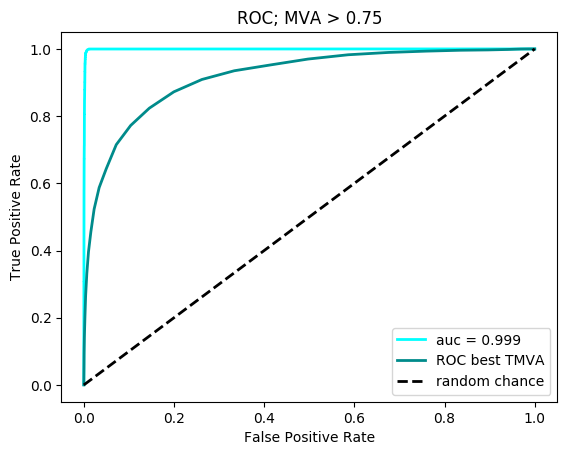

In [56]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y['MVA>75'], Ypred['MVA>75'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
plt.plot(Graph_fx1, Graph_fy1, color='darkcyan', lw=lw, label='ROC best TMVA')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC; MVA > 0.75')
plt.legend(loc="lower right")
ax.legend(loc="lower right")
plt.show()
